In [16]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()
# Set seeds for reproducibility
seed_value = 128
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Activation, dot
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adagrad, Nadam, Ftrl
#from keras.utils.vis_utils import plot_model, model_to_dot
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras.backend as K
import datetime
from tensorflow.keras import regularizers

In [ ]:
df = pd.read_csv('daily-total-female-births-CA.csv',index_col='date', parse_dates=True)
df["births"]=df["births"].astype(float)
df.head()

,births
date,
1959-01-01,35.0
1959-01-02,32.0
1959-01-03,30.0
1959-01-04,31.0
1959-01-05,44.0


In [20]:
df1 = df.to_numpy()

In [21]:
def truncate(x, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=100, test_len=20):
    in_, out_= [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
    return np.array(in_), np.array(out_)
X_in, X_out = truncate(df1, feature_cols=range(1), target_cols=range(1),label_col=1, train_len=12, test_len=1)
print(X_in.shape, X_out.shape)

(353, 12, 1) (353, 1, 1)


In [22]:
train_x = X_in[:math.floor(X_in.shape[0]*0.70)]
train_y = X_out[:math.floor(X_out.shape[0]*0.70)]
test_x = X_in[math.floor(X_in.shape[0]*0.70):]
test_y = X_out[math.floor(X_out.shape[0]*0.70):]
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(247, 12, 1) (247, 1, 1) (106, 12, 1) (106, 1, 1)


In [23]:
r=0.5 # confidence {0-1}
q = 0.95
delta = 0.003 # 0.05,0.1
l=2

def confidance_loss(y_true,y_pred):
  y_true = y_true[:,0]
  f1 = y_pred[:,0]
  f2 = y_pred[:,1]

  c1 = (1-q)*(y_true-f2)
  c2 = (1-q)*(f1-y_true)
  c3 = q*(f2-y_true)
  c4 = q*(y_true-f1)

  loss = K.switch(tf.math.logical_and((y_true <= f1),(y_true>=f2)),K.switch((y_true>r*(f1+f2)),c1,c2),K.switch((f2>y_true),c3,c4)) + (delta * tf.math.abs(f1-f2))

  return loss

In [24]:
#Model Architecture.
input_train = Input(shape=(12, 1))
initializer = tf.keras.initializers.GlorotNormal(seed=None)
lstm_l1 = LSTM(100, activation='relu',kernel_initializer=initializer,return_sequences=False)(input_train)
out = Dense(2)(lstm_l1)
model = Model(inputs=input_train, outputs=out)

In [25]:
opt = Adam(learning_rate=0.005)
model.compile(loss=confidance_loss,optimizer=opt)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 41002 (160.16 KB)
Trainable params: 41002 (160.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
epc = 300
start_time = datetime.datetime.now()
history = model.fit(train_x, train_y, validation_split=0.1, epochs=epc, verbose=1, batch_size=128)
end_time = datetime.datetime.now()
total_time = end_time - start_time
print('seconds taken:', round(total_time.total_seconds(),1),
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
2/2 [==============================] - 4s 570ms/step - loss: 32.9529 - val_loss: 11.6224
Epoch 2/300
2/2 [==============================] - 0s 70ms/step - loss: 7.3538 - val_loss: 5.2476
Epoch 3/300
2/2 [==============================] - 0s 74ms/step - loss: 5.0097 - val_loss: 4.6465
Epoch 4/300
2/2 [==============================] - 0s 74ms/step - loss: 3.7660 - val_loss: 1.8546
Epoch 5/300
2/2 [==============================] - 0s 72ms/step - loss: 2.5414 - val_loss: 37.0165
Epoch 6/300
2/2 [==============================] - 0s 76ms/step - loss: 25.2047 - val_loss: 1.7870
Epoch 7/300
2/2 [==============================] - 0s 71ms/step - loss: 1.7714 - val_loss: 3.0315
Epoch 8/300
2/2 [==============================] - 0s 82ms/step - loss: 2.8804 - val_loss: 3.5570
Epoch 9/300
2/2 [==============================] - 0s 83ms/step - loss: 3.0628 - val_loss: 3.2757
Epoch 10/300
2/2 [==============================] - 0s 82ms/step - loss: 2.9043 - val_loss: 2.9290
Epoch 11/300
2

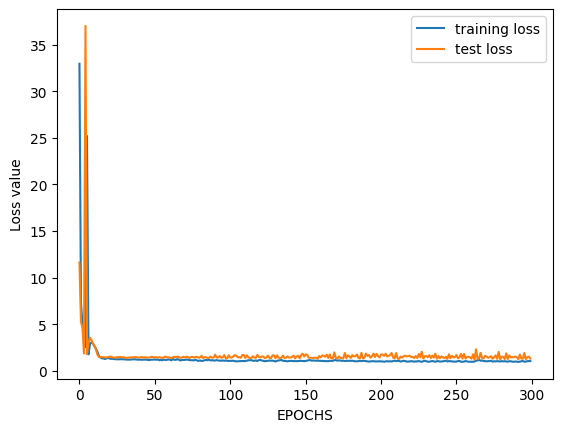

In [27]:
fig,ax = plt.subplots()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
ax.set_xlabel('EPOCHS')
ax.set_ylabel('Loss value')
plt.legend()

In [28]:
y_pred = model.predict(test_x, verbose=0)
test_y_ = np.squeeze(test_y[:,0])
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
print('PICP:', np.mean(K_u * K_l))
print('MPIW:', np.round(np.mean(y_u_pred - y_l_pred),3))

PICP: 0.9528301886792453
MPIW: 26.975


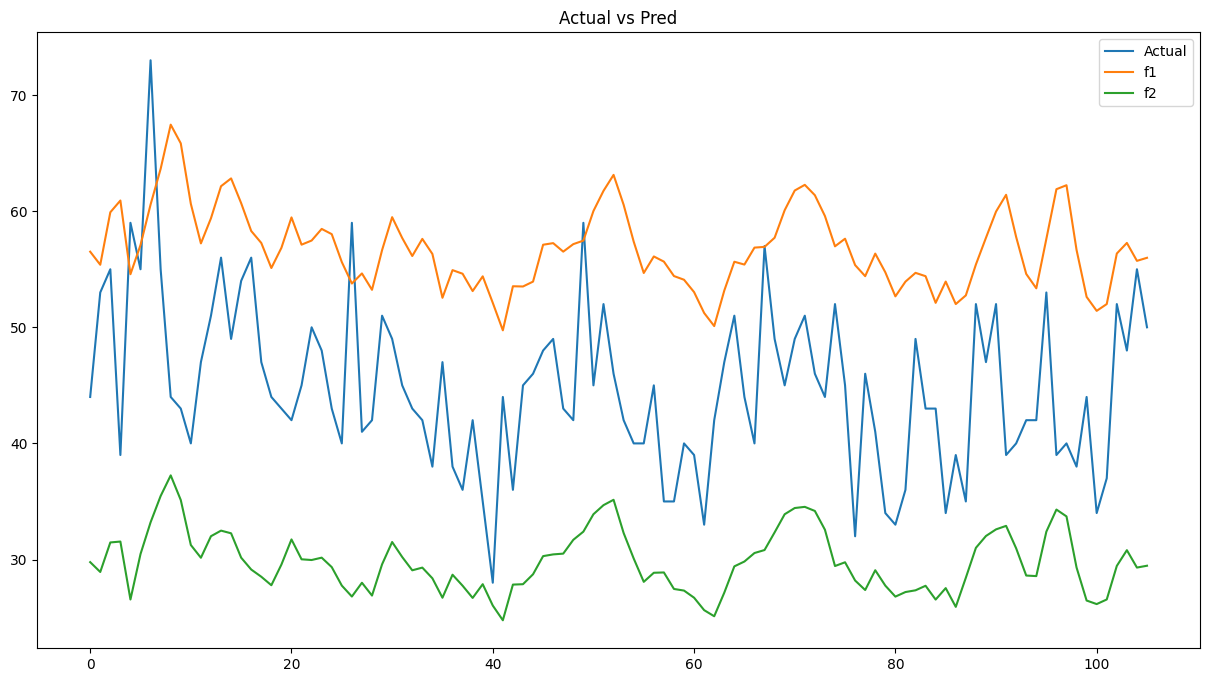

In [29]:
actual=test_y
actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = range(len(actual))
plt.figure(figsize=(15, 8))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='f1')
plt.plot(numEx,pred2,label='f2')
plt.legend(loc='best')
plt.title('Actual vs Pred')
plt.show()